Plots the measured air quality variables for a county over the 5-year intervals

In [ ]:
###Change this to your repo location
homedir = "/Users/ennesser.1//Documents/Erdos22/Capstone-/"

In [5]:
from matplotlib import pyplot as plt
import matplotlib._color_data as mcd
import numpy as np
import pandas as pd
import os
import plotly, json
import plotly.express as px
from urllib.request import urlopen

In [6]:
def flatten_df(df, filter_by = {}, save_fn = None): 
    
    sort_by = {'Gender Code' : None,
               'Race' : None,
               'Hispanic Origin' : None,
               'Interval' : None,
               'Age Group Code': None,
               'State' : None}
    county_level_cols = ['County','5_Year_Avg_Poverty_Estimate','Total 5yrAvg County Population',
                         'Total 5yrAvg County Population','Total 5yrAvg County Deaths',
                         'Total 5yrAvg State Population','Total 5yrAvg State Deaths',
                         'Total 15yrAvg County Population','Total 15yrAvg County Deaths',
                         'Total 15yrAvg State Population','Total 15yrAvg State Deaths','15_Year_Avg_Poverty_Estimate',
                         'CO 2nd Max 1-hr', 'CO 2nd Max 8-hr','NO2 98th Percentile 1-hr', 
                         'NO2 Mean 1-hr', 'Ozone 2nd Max 1-hr', 'Ozone 4th Max 8-hr', 
                         'SO2 99th Percentile 1-hr', 'SO2 2nd Max 24-hr','SO2 Mean 1-hr', 
                         'PM2.5 98th Percentile 24-hr', 'PM2.5 Weighted Mean 24-hr', 
                         'PM10 2nd Max 24-hr', 'Lead Max 3-Mo Avg']
    air_q_cols = ['CO 2nd Max 1-hr', 'CO 2nd Max 8-hr','NO2 98th Percentile 1-hr', 
                  'NO2 Mean 1-hr', 'Ozone 2nd Max 1-hr', 'Ozone 4th Max 8-hr', 
                  'SO2 99th Percentile 1-hr', 'SO2 2nd Max 24-hr','SO2 Mean 1-hr', 
                  'PM2.5 98th Percentile 24-hr', 'PM2.5 Weighted Mean 24-hr', 
                  'PM10 2nd Max 24-hr', 'Lead Max 3-Mo Avg']
    
    # Check for bad input
    for key in filter_by.keys(): 
        if key not in sort_by: 
            print('Unrecognized key in filter_by dict.')
            return
    
    for key in filter_by:
        if filter_by[key] != None: sort_by[key] = filter_by[key]
    
    # Deal with interval issues
    temp_df = df.copy(deep=True)
    if sort_by['Interval'] != None: 
        num_years = 5
        mask = np.asarray(temp_df['Interval']==sort_by['Interval'])
        temp_df = temp_df.loc[mask]
        
    else: 
        num_years = 15
        fips = np.unique(temp_df['FIPS'].astype(str))
        for fip in fips:
            temp = temp_df.loc[temp_df['FIPS']==fip]
            all_ints,ind = np.unique(temp['Interval'],return_index=True)
            for quant in air_q_cols:
                mask = temp_df['FIPS'] == fip
                temp_df.loc[mask,quant] = np.nanmean(temp.iloc[ind][quant])

    # Remove all unnecesary data from the df
    for key,val in sort_by.items():
        if val == None: 
            temp_df = temp_df.drop(columns=key)
        else:    
            temp_df = temp_df.loc[np.asarray(temp_df[key]==val)]
            
    # Flatten remaining data points so that there are no repeated counties/FIPS
    fips,ind = np.unique(temp_df['FIPS'].astype(str),return_index=True)
    
    ### Get values that are constant for different groups in the same county
    county_levels = {}
    for col in county_level_cols:
        county_levels[col] = np.asarray(temp_df[col])[ind]
        
    ### Calculate the values that change with different groups in the same county
    deaths = []
    population = []
    for fip in fips:
        mask = np.asarray(temp_df['FIPS']==fip)
        single_county_df = temp_df.loc[mask]
        deaths.append(np.sum(single_county_df['Deaths']))
        population.append(np.sum(single_county_df['Population']))
    
    ### Calculate deaths and population per year
    deaths = np.asarray(deaths)/num_years
    population = np.asarray(population)/num_years
    
    # Construct dataframe
    flattened_df = pd.DataFrame(data={'FIPS': fips, 'Deaths': deaths, 'Population': population})
    for col in county_level_cols:
        if sort_by['Interval'] != None:
            flattened_df[col] = county_levels[col]
        elif ' 5yrAvg' not in col and '5_Year_Avg_Poverty_Estimate' != col:
            flattened_df[col] = county_levels[col]
    
    # Save to CSV if necessary
    if save_fn != None:
        flattened_df.to_csv(save_fn)
    
    return flattened_df # dataframe with single row for each county containing deaths, population, poverty, and polution

In [7]:
###Select your population
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response: counties = json.load(response)
mortDF = pd.read_csv(homedir+'/data/mort_airq_poverty.csv',dtype={"FIPS": str})
mort_flattened = flatten_df(mortDF,{'Race': 'African American','Interval': '2002-2006'})

In [8]:
def aq_vs_mort(mort_flattened,aqVar,popVar,rate=False,total=False):

    """ 
    Eradicate aq 'nan's, can caluculate death rates/county
    
    Arguments:
        mort_flattened : dataframe, flatted mort dataframe
        aqVar : str, air quality varible to plot (column name)
        popVar : str, population variable to plot (column name)
        rate : bool, use "True" if you want death rates
        total: bool, use "True" if you want total county deaths
        
    Returns:
        lists that can be plotted.
    
    """
    
    pop_array = mort_flattened[popVar].to_numpy()
    if rate==True:
        death_array = mort_flattened['Deaths'].to_numpy()
        death_total_array = mort_flattened['Total 5yrAvg County Deaths'].to_numpy()
    
    if total==True:
        death_array=death_total_array
    
    aq_array = mort_flattened[aqVar].to_numpy()
    pop_list = []
    aq_list = []
    
    for c,county in enumerate(aq_array):
        
        #check that aq value exists, skip if 'nan'
        if np.isnan(county) == True:
            continue
        
        aq_list.append(county)

        if rate == True: 
            deathrate = death_array[c]/pop_array[c]
            pop_list.append(deathrate)
        
        else:
            pop_list.append(pop_array[c])

    return aq_list, pop_list    

02-06
07-11
12-16
02-06
07-11
12-16
02-06


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/2956023729.py:25: RuntimeWarning: divide by zero encountered in log
  total_pop = np.log(total_pop)


07-11


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/4206999980.py:47: RuntimeWarning: invalid value encountered in double_scalars
  deathrate = death_array[c]/pop_array[c]


12-16


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/2956023729.py:25: RuntimeWarning: divide by zero encountered in log
  total_pop = np.log(total_pop)


02-06


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/2956023729.py:25: RuntimeWarning: divide by zero encountered in log
  total_pop = np.log(total_pop)


07-11


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/4206999980.py:47: RuntimeWarning: invalid value encountered in double_scalars
  deathrate = death_array[c]/pop_array[c]


12-16


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/2956023729.py:25: RuntimeWarning: divide by zero encountered in log
  total_pop = np.log(total_pop)


02-06


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/2956023729.py:25: RuntimeWarning: divide by zero encountered in log
  total_pop = np.log(total_pop)


07-11


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/4206999980.py:47: RuntimeWarning: invalid value encountered in double_scalars
  deathrate = death_array[c]/pop_array[c]


12-16


/var/folders/x4/5s__z2p568vfs6v3vm5c6j75mhq59b/T/ipykernel_12496/2956023729.py:25: RuntimeWarning: divide by zero encountered in log
  total_pop = np.log(total_pop)


02-06
07-11
12-16


array([[<AxesSubplot:xlabel='CO 2nd Max 8-hr'>,
        <AxesSubplot:xlabel='NO2 Mean 1-hr'>],
       [<AxesSubplot:xlabel='Ozone 4th Max 8-hr'>,
        <AxesSubplot:xlabel='SO2 Mean 1-hr'>],
       [<AxesSubplot:xlabel='PM2.5 Weighted Mean 24-hr'>,
        <AxesSubplot:xlabel='Lead Max 3-Mo Avg'>]], dtype=object)

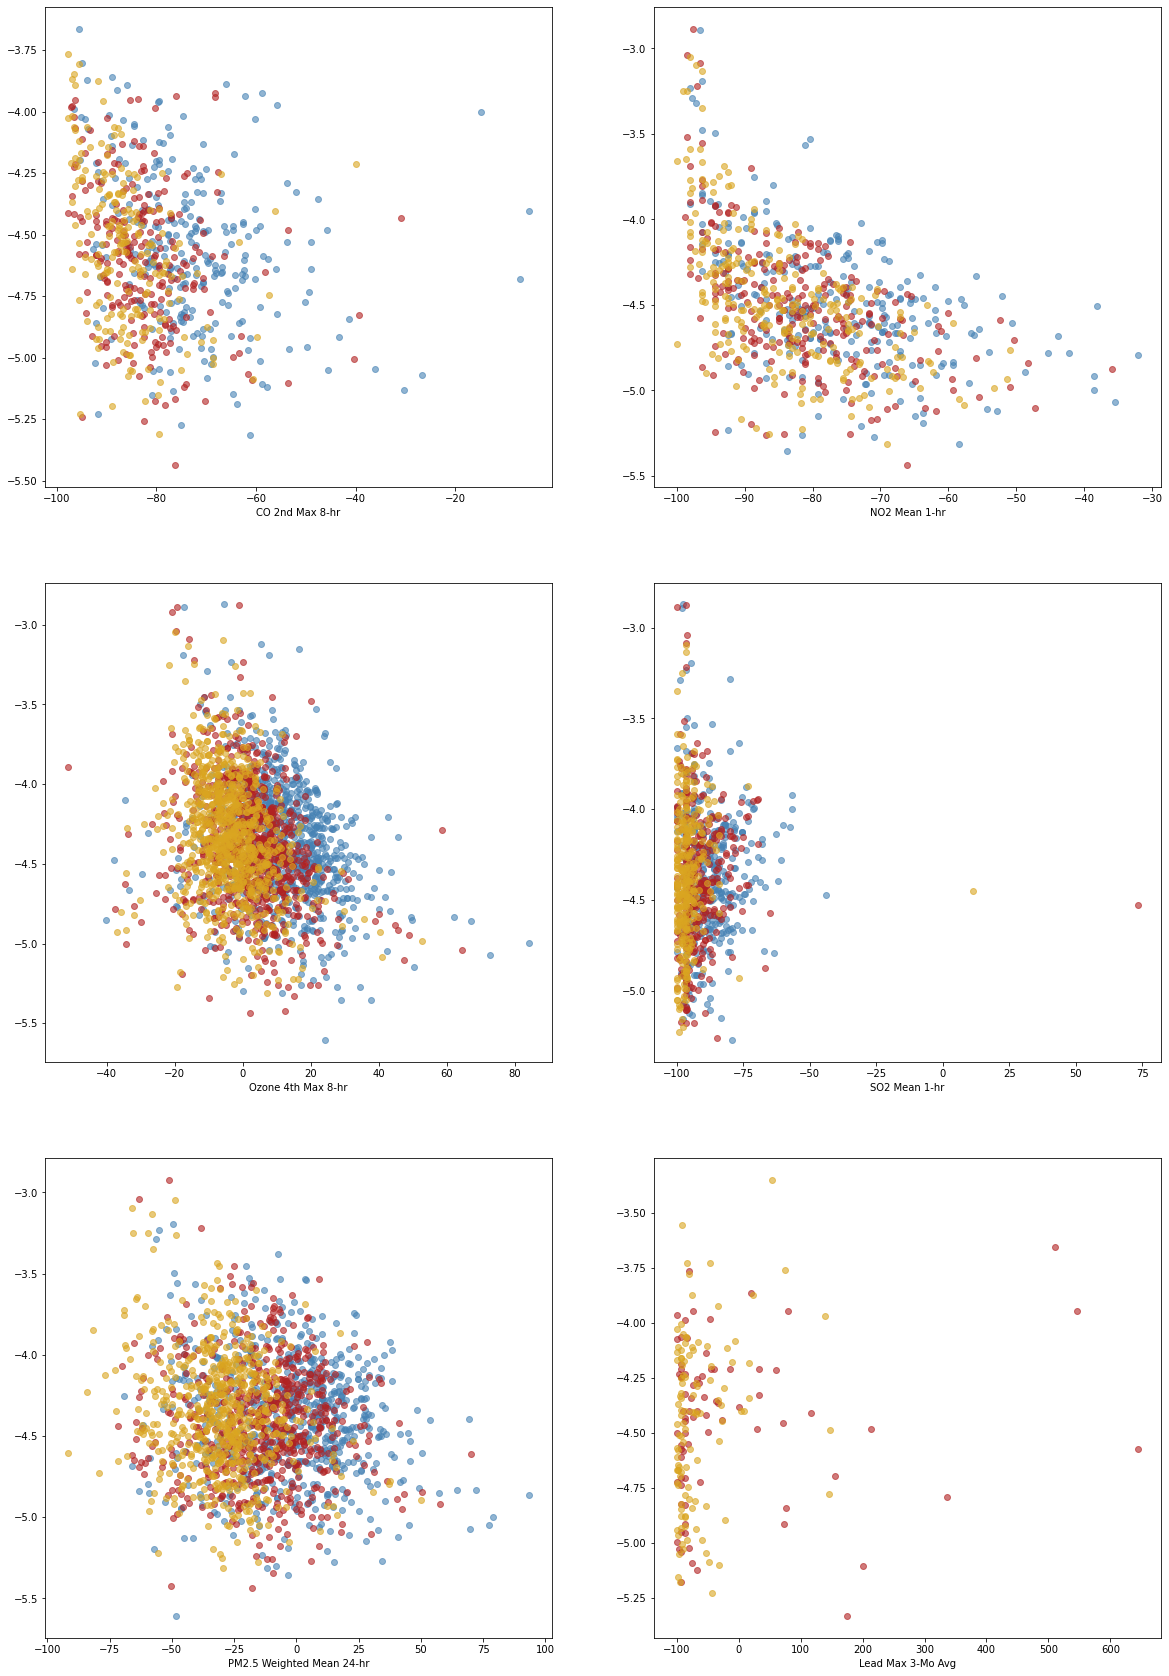

In [16]:
###Plots the approximate annual averages for each recorded air polluntant for a county
###in the three 5-year intervals. 
mortIntervals = ['2002-2006','2007-2011','2012-2016']

#Change this if you want to look at a different population
mortVar = 'Total 5yrAvg County Population'
log=True
rate=True
total=True

aq_annuals = ['CO 2nd Max 8-hr', 'NO2 Mean 1-hr', 'Ozone 4th Max 8-hr', 'SO2 Mean 1-hr', 'PM2.5 Weighted Mean 24-hr','Lead Max 3-Mo Avg']
fig,axs = plt.subplots(3,2,figsize=(20,30))
axs = np.ravel(axs)
colors = [mcd.CSS4_COLORS['steelblue'],mcd.CSS4_COLORS['firebrick'],mcd.CSS4_COLORS['goldenrod']]

for j, aqVar in enumerate(aq_annuals):
    
    for i,interval in enumerate(aqYears):
        mort_flattened = flatten_df(mortDF,{'Race': 'White','Interval': mortIntervals[i]})    
        aq_list, total_pop = aq_vs_mort(mort_flattened,aqVar,mortVar,rate,total)
    
        if log==True:
            total_pop = np.log(total_pop)
    
        axs[j].scatter(aq_list, total_pop, color=colors[i], label=mortIntervals, alpha=0.6)
        axs[j].set_xlabel(aqVar)

np.reshape(axs,(3,2))

In [40]:
###Print counties that show an increase in air pollution? Prints the county names and percent difference.
mortIntervals = ['2002-2006','2007-2011','2012-2016']

aq_annuals = ['CO 2nd Max 8-hr', 'NO2 Mean 1-hr', 'Ozone 4th Max 8-hr', 'SO2 Mean 1-hr', 'PM2.5 Weighted Mean 24-hr']

mortVar = 'Total 5yrAvg County Population'
log=False
rate=True

for j, aqVar in enumerate(aq_annuals):
    
    aq_list_ints = []
    negs3 = []
    negcounties = []
    
    for i,interval in enumerate(aqYears):
        mort_flattened = flatten_df(mortDF,{'Race': 'White','Gender Code': 'F', 'Interval': mortIntervals[i]})

        aq_array = mort_flattened[aqVar].to_numpy()
        aq_list_ints.append(aq_array)
        
        counties = mort_flattened['County'].to_numpy()

    for c,county in enumerate(aq_list_ints[0]):
        if np.isnan(county) == True:
            continue
        
        if np.isnan(aq_list_ints[1][c]) == True:
            continue
        
        aq_diff1 = county-aq_list_ints[1][c]
        
        if np.isnan(aq_list_ints[2][c]) == True:
            continue
            
        aq_diff2 = aq_list_ints[1][c]-aq_list_ints[2][c]
        aq_diff3 = county-aq_list_ints[2][c]
    
        if aq_diff3 < 0:
            negs3.append(aq_diff3)
            negcounties.append(counties[c])
            
    print(negcounties)
    print(negs3)


02-06
3147
07-11
3147
12-16
3147
['Santa Barbara County, CA', 'Vanderburgh County, IN', 'Cumberland County, ME', 'Dakota County, MN', 'Douglas County, NV', 'Cuyahoga County, OH']
[-0.8888888888888999, -5.1111111111111, -5.1111111111111, -5.333333333333329, -7.555555555555557, -3.777777777777793]
02-06
3147
07-11
3147
12-16
3147
['Alameda County, CA', 'Fulton County, GA', 'Scott County, IA', 'Rosebud County, MT', 'Dunn County, ND', 'McKenzie County, ND', 'Travis County, TX', 'Campbell County, WY']
[-1.1320754716981298, -4.905660377358494, -1.5094339622641542, -0.37735849056603854, -0.37735849056603854, -0.37735849056603854, -10.84905660377359, -3.7735849056603854]
02-06
3147
07-11
3147
12-16
3147
['Madera County, CA', 'Marin County, CA', 'San Francisco County, CA', 'San Mateo County, CA', 'Sonoma County, CA', 'Adams County, CO', 'La Plata County, CO', 'Honolulu County, HI', 'Palo Alto County, IA', 'Story County, IA', 'Riley County, KS', 'Lancaster County, NE', 'Churchill County, NV', 'C

In [39]:
###This is for printing numbers for a single county. I don't think we'll end up using it, but it's fun to 
###look at.

#You'll need the 5-digit FIPS county code
fips_cs = '22087'

mortIntervals = ['2002-2006','2007-2011','2012-2016']

aq_annuals = ['CO 2nd Max 8-hr', 'NO2 Mean 1-hr', 'Ozone 4th Max 8-hr', 'SO2 Mean 1-hr', 'PM2.5 Weighted Mean 24-hr']

mortVars = ['Total 5yrAvg County Population','5_Year_Avg_Poverty_Estimate','Total 5yrAvg County Deaths']
log=False
rate=True
    
for i,interval in enumerate(aqYears):
    mort_flattened = flatten_df(mortDF,{'Race': 'Black or African American','Interval': mortIntervals[i]})
    
    case_index = np.where(mort_flattened['FIPS']==fips_cs)[0][0]
    
    print(mort_flattened['County'][case_index])
    for j,var in enumerate(mortVars):
        print(var)
        print(mort_flattened[var][case_index])
        
    deathrate = mort_flattened['Total 5yrAvg County Deaths'][case_index]/mort_flattened['Total 5yrAvg County Population'][case_index]
    print('death rate')
    print(deathrate)
    print('poverty rate')
    povertyrate = mort_flattened['5_Year_Avg_Poverty_Estimate'][case_index]/mort_flattened['Total 5yrAvg County Population'][case_index]
    print(povertyrate)
    print('Ozone')
    print(mort_flattened['Ozone 4th Max 8-hr'][case_index])
    print('PM')
    print(mort_flattened['PM2.5 Weighted Mean 24-hr'][case_index])
    print('Black deathrate')
    deathrate = mort_flattened['Deaths'][case_index]/mort_flattened['Population'][case_index]
    print(deathrate)
    

St. Bernard Parish, LA
Total 5yrAvg County Population
41126.4
5_Year_Avg_Poverty_Estimate
8043.6
Total 5yrAvg County Deaths
676.8
death rate
0.01645658263305322
poverty rate
0.19558239962651727
Ozone
10.47619047619046
PM
-3.6111111111110974
Black deathrate
0.018988872762457667
St. Bernard Parish, LA
Total 5yrAvg County Population
16376.6
5_Year_Avg_Poverty_Estimate
6820.8
Total 5yrAvg County Deaths
248.0
death rate
0.015143558491994676
poverty rate
0.41649670871853745
Ozone
3.1428571428571583
PM
-10.83333333333334
Black deathrate
0.015005049776367047
St. Bernard Parish, LA
Total 5yrAvg County Population
21010.6
5_Year_Avg_Poverty_Estimate
9246.4
Total 5yrAvg County Deaths
315.6
death rate
0.015020989405347778
poverty rate
0.44008262496073414
Ozone
-5.428571428571427
PM
-29.166666666666664
Black deathrate
0.012433908546859567
